# RAPIDS & Scanpy Single-Cell RNA-seq Workflow

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2 and TMPRSS2 genes.

## Import requirements

In [1]:
import scanpy as sc
import anndata

In [2]:
import time
import os
import wget

In [3]:
import cudf
import cupy as cp
import numpy as np


In [4]:
from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler


/home/sam3557/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import rapids_scanpy_funcs
import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [6]:
import rmm
rmm.reinitialize(
    managed_memory=False,  # Disable - causes fragmentation
    pool_allocator=True,
    initial_pool_size=int(8e9),   # 8GB fixed pool
    maximum_pool_size=int(12e9),  # No oversubscription
    devices=[0]
)


We use the RAPIDS memory manager on the GPU to control how memory is allocated.

## Input data

In the cell below, we provide the path to the `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

We recommend saving count matrices in the sparse .h5ad format as it is much faster to load than a dense CSV file. To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [7]:
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [8]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [9]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [10]:
data_load_start = time.time()

In [11]:
%%time
adata = sc.read(input_file)
adata.X = adata.X.astype(np.float32)

CPU times: user 150 ms, sys: 633 ms, total: 783 ms
Wall time: 4.49 s


We maintain the index of unique genes in our dataset:

In [12]:
%%time
genes = cudf.Series(adata.var_names)
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 73.9 ms, sys: 553 ms, total: 627 ms
Wall time: 693 ms


Verify the shape of the resulting sparse matrix:

In [13]:
sparse_gpu_array.shape

(65662, 26485)

And the number of non-zero values in the matrix:

In [14]:
sparse_gpu_array.nnz

126510394

In [15]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 5.2203028202056885


## Preprocessing

In [16]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [17]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 279 ms, sys: 484 ms, total: 764 ms
Wall time: 800 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [18]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 1.02 s, sys: 85.8 ms, total: 1.11 s
Wall time: 1.14 s


The size of our count matrix is now reduced.

In [19]:
sparse_gpu_array.shape

(65462, 22058)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)

CPU times: user 994 μs, sys: 361 μs, total: 1.36 ms
Wall time: 1.43 ms


Next, we log transform the count matrix.

In [21]:
%%time
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 56.9 ms, sys: 3.98 ms, total: 60.8 ms
Wall time: 61.2 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset. However, we first save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of an epithelial marker gene (EPCAM).

In [22]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 249 ms, sys: 49.7 ms, total: 298 ms
Wall time: 305 ms


We identify the top 5000 variable genes using the `cellranger` method.

In [23]:
%%time
hvg = rapids_scanpy_funcs.highly_variable_genes(sparse_gpu_array, genes, n_top_genes=5000)

CPU times: user 160 ms, sys: 20.1 ms, total: 180 ms
Wall time: 186 ms


We filter the count matrix to retain only the 5000 most variable genes.

In [24]:
%%time
sparse_gpu_array = sparse_gpu_array[:, hvg]
genes = genes[hvg].reset_index(drop=True)
sparse_gpu_array.shape

CPU times: user 41.7 ms, sys: 2.44 ms, total: 44.2 ms
Wall time: 45.1 ms


(65462, 5000)

### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

In [25]:
ribo_genes = genes.str.startswith(RIBO_GENE_PREFIX)

We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [26]:
%%time
n_counts = sparse_gpu_array.sum(axis=1)
percent_ribo = (sparse_gpu_array[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 11.2 ms, sys: 447 μs, total: 11.7 ms
Wall time: 11.4 ms


And perform regression:

In [27]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_ribo)

CPU times: user 745 ms, sys: 247 ms, total: 991 ms
Wall time: 1.01 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [28]:
%%time
sparse_gpu_array = cp.clip(StandardScaler().fit_transform(sparse_gpu_array), a_min = -10, a_max=10)

CPU times: user 780 ms, sys: 2.48 s, total: 3.26 s
Wall time: 3.46 s


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.115079402923584


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [30]:
%%time

adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()

for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 161 ms, sys: 140 ms, total: 301 ms
Wall time: 301 ms


### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [31]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)

CPU times: user 1.2 s, sys: 6.98 s, total: 8.18 s
Wall time: 9.43 s


### T-SNE + k-Means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [32]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

[2025-02-19 21:08:40.599] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.24 s, sys: 224 ms, total: 1.47 s
Wall time: 1.46 s


We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [33]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 139 ms, sys: 27.9 ms, total: 167 ms
Wall time: 179 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

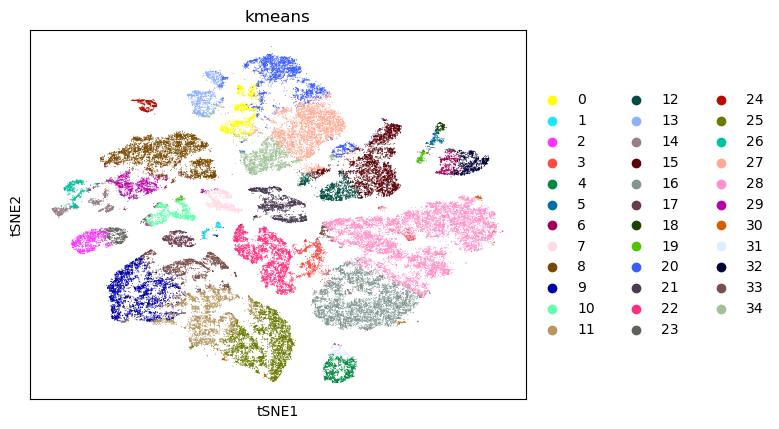

CPU times: user 698 ms, sys: 0 ns, total: 698 ms
Wall time: 704 ms


In [34]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

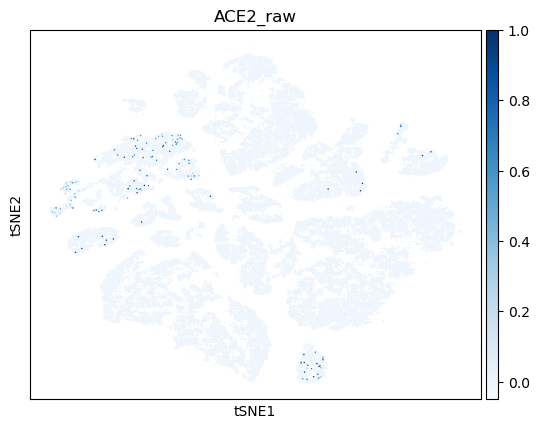

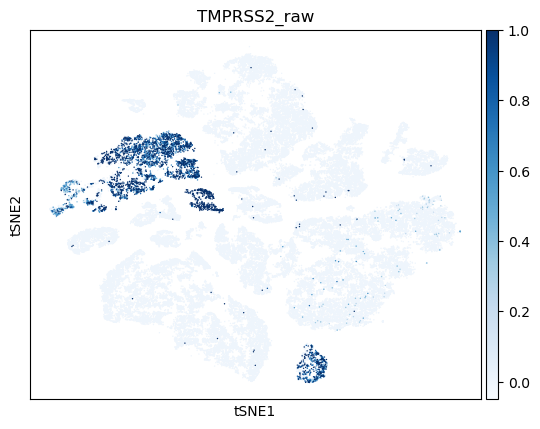

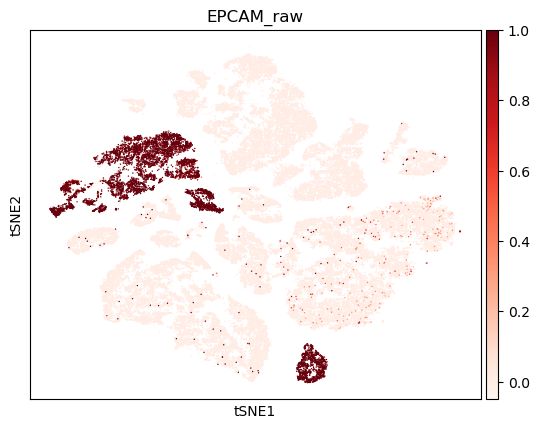

CPU times: user 1.02 s, sys: 9.74 ms, total: 1.03 s
Wall time: 1.02 s


In [35]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [36]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 1.86 s, sys: 278 ms, total: 2.14 s
Wall time: 2.04 s


The UMAP function from Rapids is also integrated into Scanpy.

In [37]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

[2025-02-19 21:08:46.031] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CPU times: user 385 ms, sys: 26.8 ms, total: 412 ms
Wall time: 409 ms


Next, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [38]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 360 ms, sys: 118 ms, total: 477 ms
Wall time: 493 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

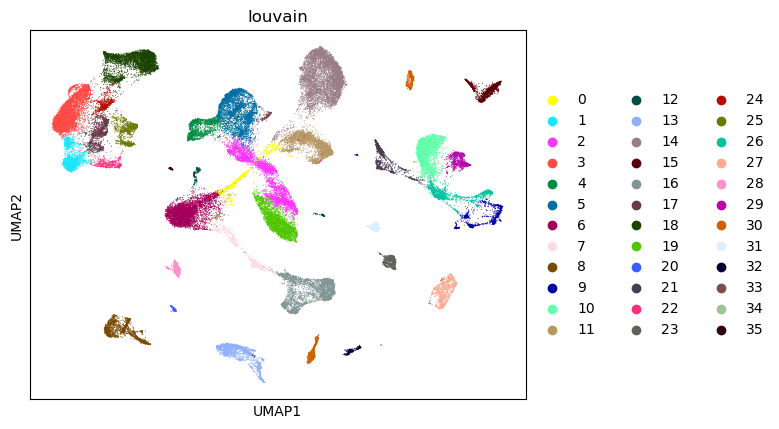

CPU times: user 648 ms, sys: 30.5 ms, total: 678 ms
Wall time: 672 ms


In [39]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [40]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 277 ms, sys: 129 ms, total: 406 ms
Wall time: 407 ms


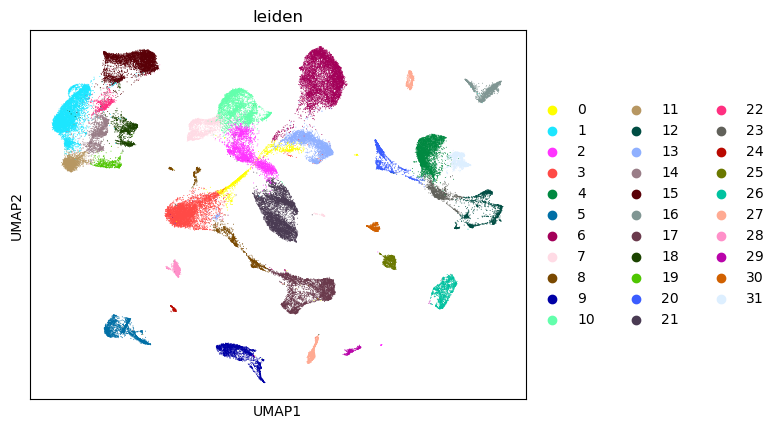

CPU times: user 636 ms, sys: 8.9 ms, total: 645 ms
Wall time: 638 ms


In [41]:
%%time
sc.pl.umap(adata, color=["leiden"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

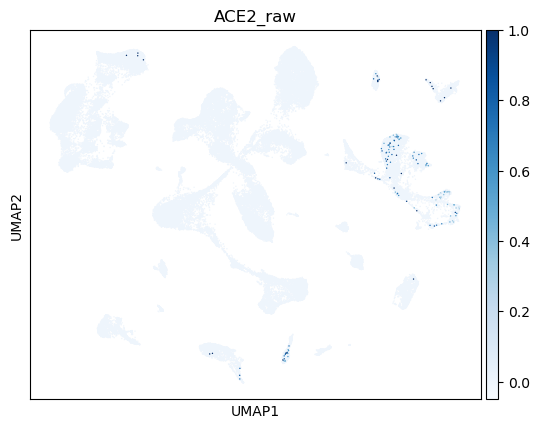

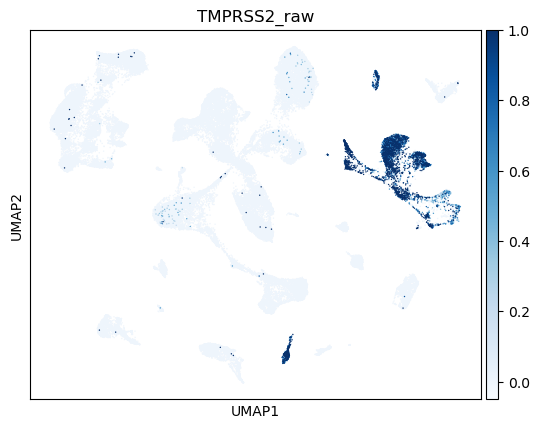

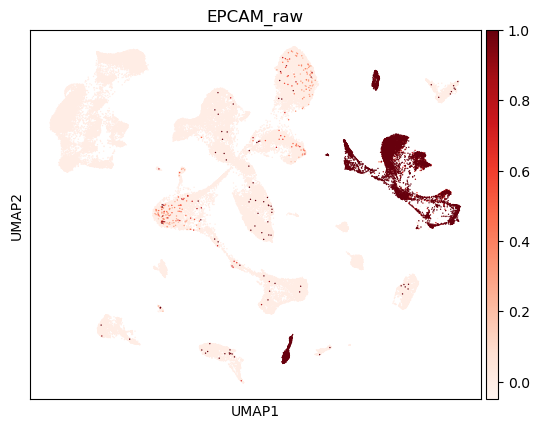

CPU times: user 825 ms, sys: 6.95 ms, total: 832 ms
Wall time: 824 ms


In [42]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [43]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(adata, 
                                                                 groupby="louvain",
                                                                 n_genes=ranking_n_top_genes, 
                                                                 groups='all', 
                                                                 reference='rest')

CPU times: user 5.69 s, sys: 5.58 s, total: 11.3 s
Wall time: 11.4 s


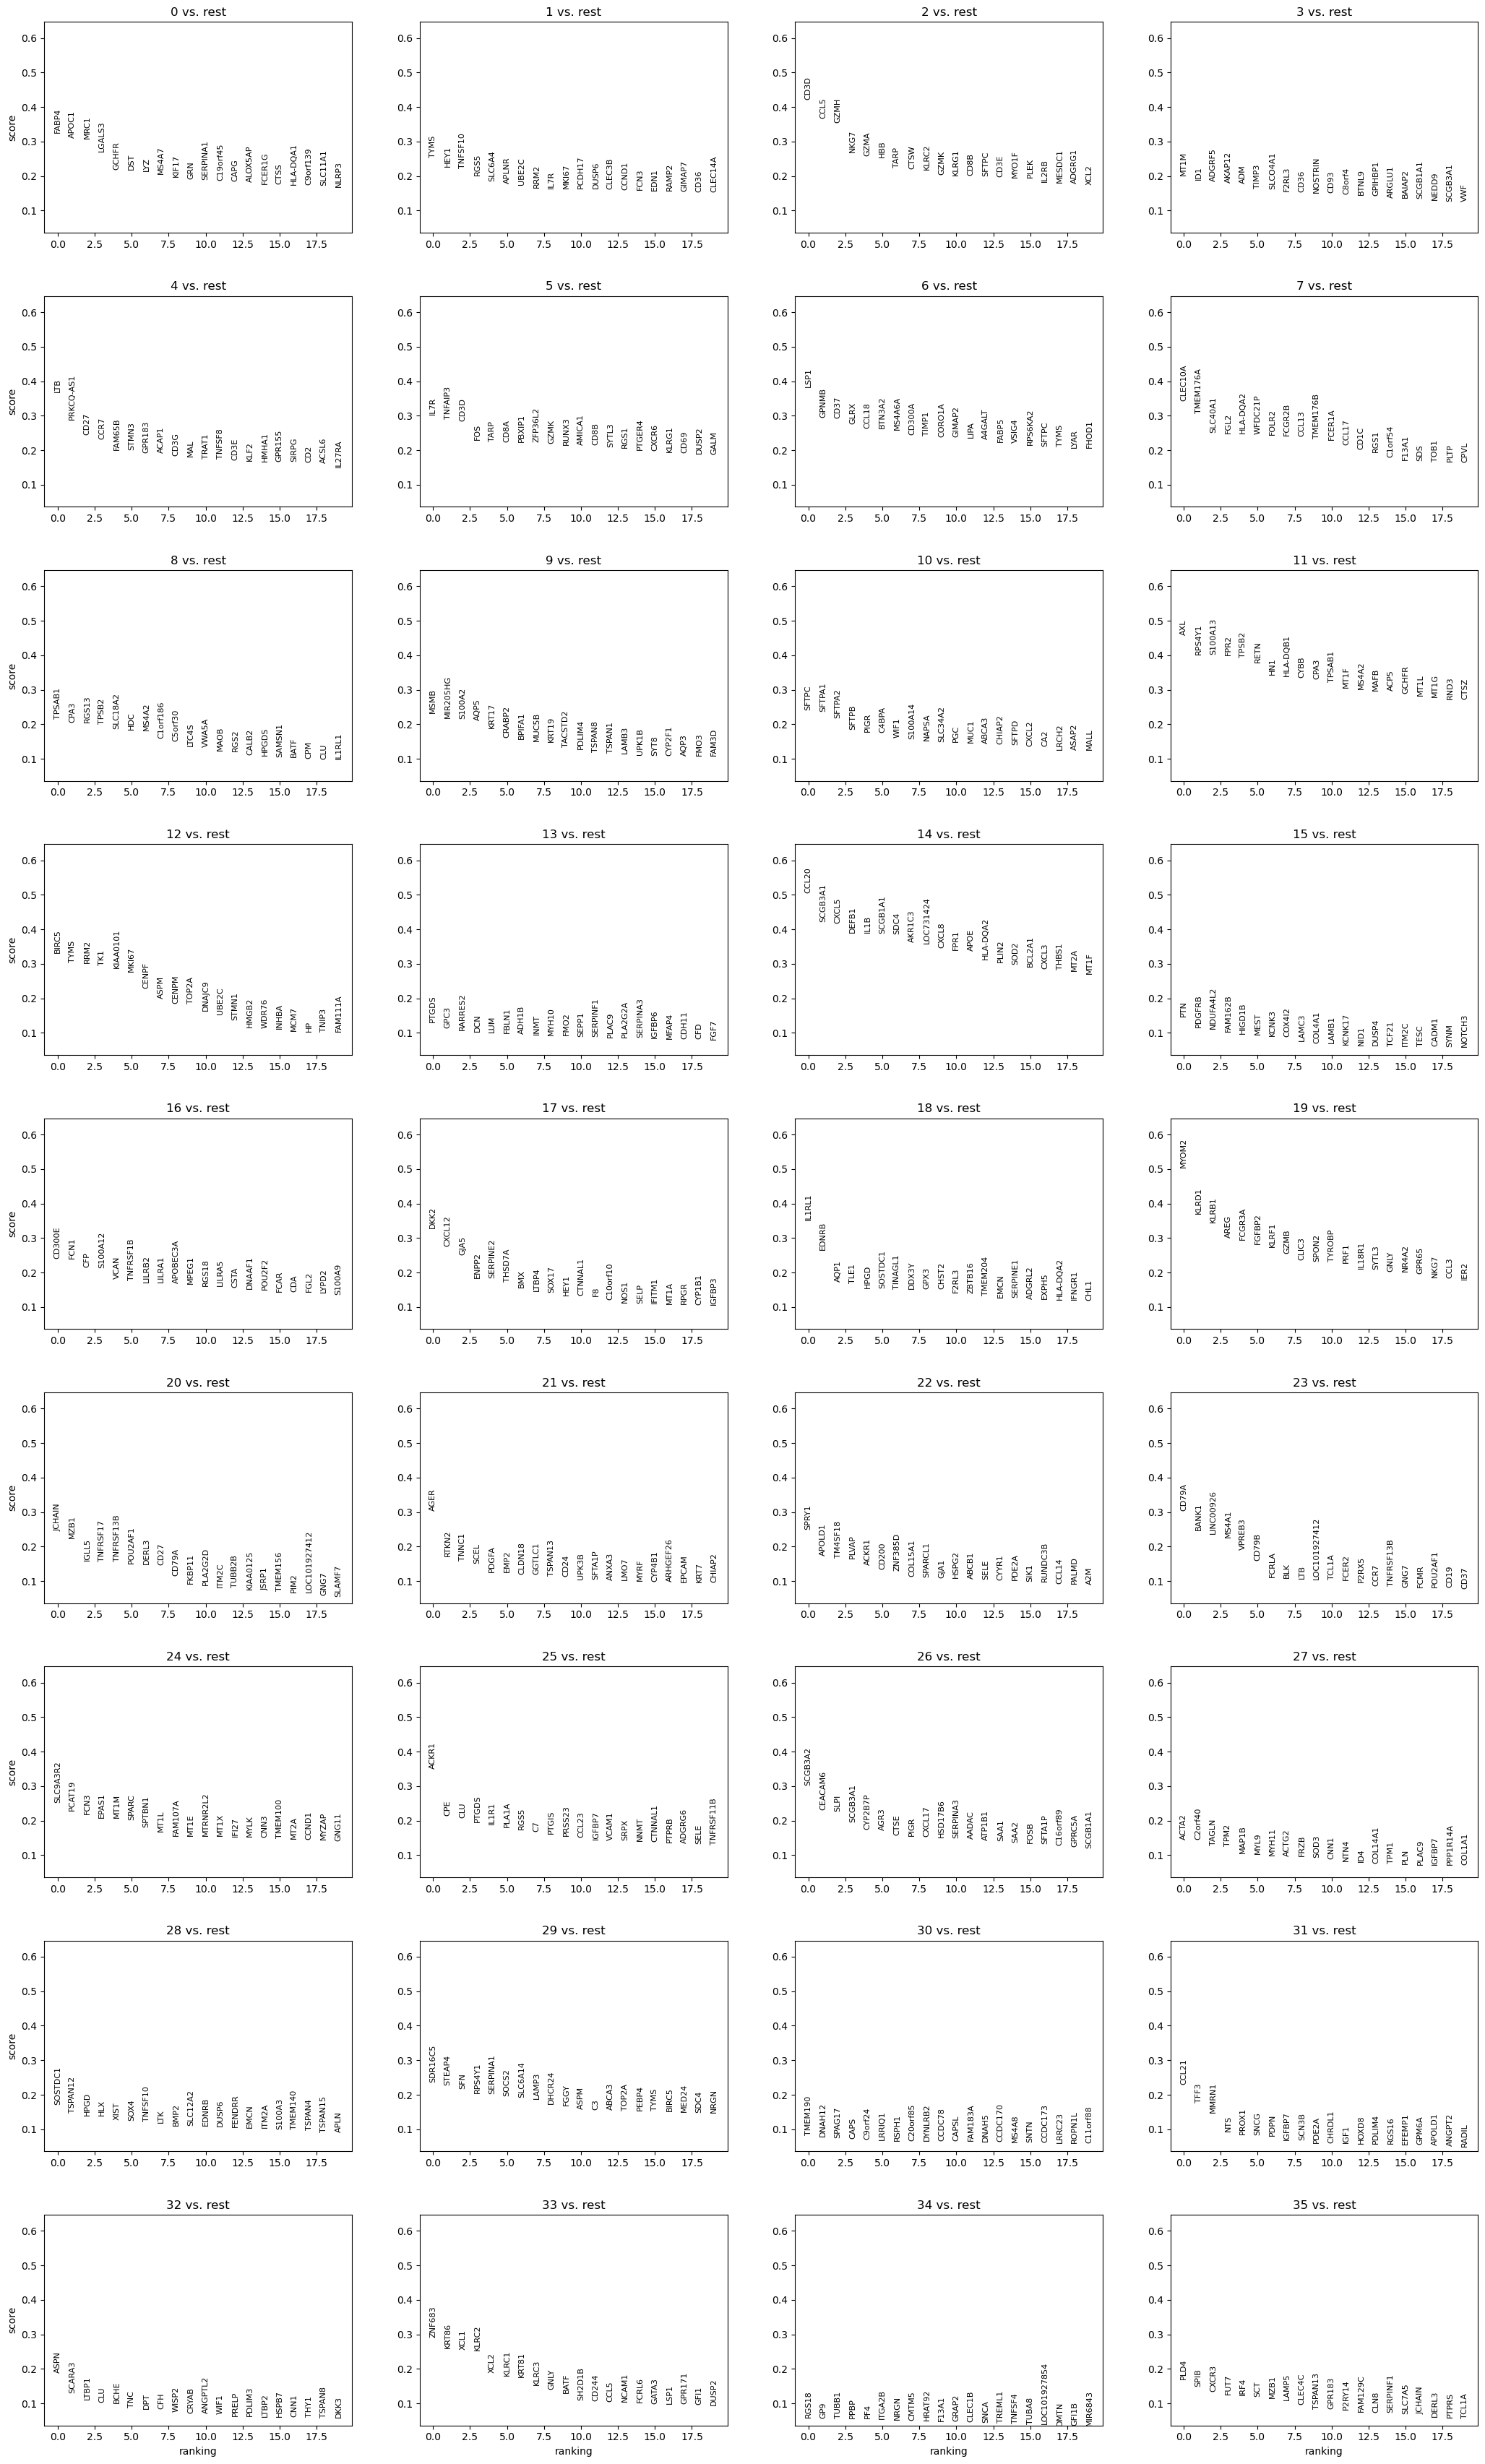

CPU times: user 3.08 s, sys: 45.3 ms, total: 3.13 s
Wall time: 3.1 s


In [44]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [45]:
reanalysis_start = time.time()

In [46]:
%%time
epcam_cells = adata.obs["EPCAM_raw"] > 0.0
adata = adata[epcam_cells,:]
adata.shape

CPU times: user 2.02 ms, sys: 1.36 ms, total: 3.38 ms
Wall time: 3.09 ms


(7958, 5000)

In [47]:
import rapids_singlecell as rsc
print(rsc.__version__)  # Should show 0.11.1+


0.11.1


In [48]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)
rsc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

[2025-02-19 21:09:05.138] [CUML] [debug] n_neighbors=15
[2025-02-19 21:09:05.138] [CUML] [debug] Calling knn graph run
[2025-02-19 21:09:05.138] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-02-19 21:09:05.138] [CUML] [debug] Smooth kNN Distances
[2025-02-19 21:09:05.138] [CUML] [debug] Compute Membership Strength
[2025-02-19 21:09:05.190] [CUML] [debug] Done. Calling remove zeros
[2025-02-19 21:09:05.205] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CPU times: user 857 ms, sys: 534 ms, total: 1.39 s
Wall time: 1.4 s


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

And plot the results:

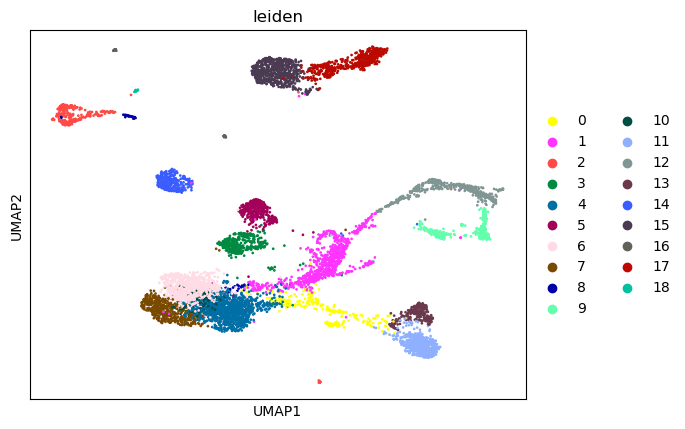

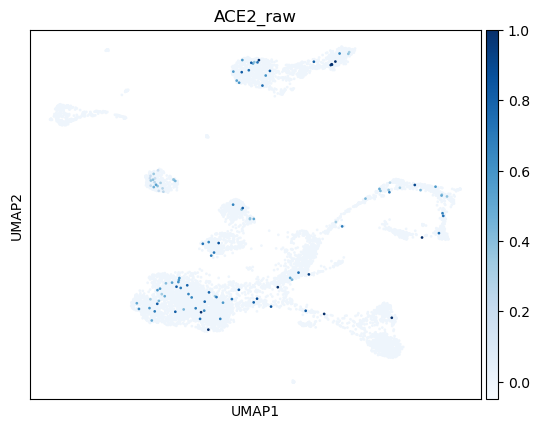

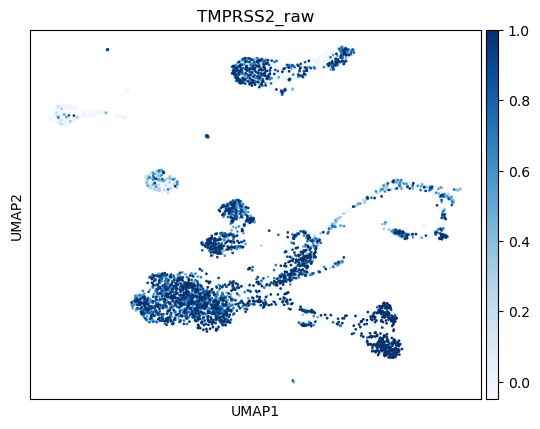

CPU times: user 694 ms, sys: 13.8 ms, total: 707 ms
Wall time: 700 ms


In [49]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [50]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 2.175114154815674


In [51]:
print("Full time: %s" % (time.time() - start))

Full time: 47.69152760505676
